In [2]:
# !pip install pandas
import pandas as pd
import numpy as np
from experiment import ExperimentRunner, Param
import matplotlib.pyplot as plt
import itertools
import random
from collections import namedtuple

%load_ext autoreload
%autoreload 2

In [3]:
thief_spawn_y=(0.0, 10.0)
Param(thief_spawn_y).value

5.5281099947706664

In [4]:
er = ExperimentRunner(time_precision=0.1, n_digits=2,
     thief_spawn_x=0.0, thief_spawn_y=(0.0, 9.0), thief_speed=1.0,
     projectile_spawn_x=9.0, projectile_spawn_y=(5.0, 5.0),
     projectile_speed=3.0, projectile_angle_diapason_dgr=(0.0, 360.0)
)

In [5]:
er.run_experiments(times=100000) # Guaranteee we have at least 2 HIT samples

In [6]:
len(er.data_samples[0])

10

In [7]:
df = pd.DataFrame(er.data_samples, columns = [
    "thief_spawn_x", 
    "thief_spawn_y",
    "thief_speed",
    "projectile_spawn_x",
    "projectile_spawn_y",
    "projectile_speed",
    "projectile_angle_degrees",
    "is_hit",
    "projectile_intersection_x",
    "projectile_intersection_y"
])

print(f"Hit samples: {len(df[df['is_hit']==True])}")
df.head(2)
er = ExperimentRunner(time_precision=0.1, n_digits=2,
     thief_spawn_x=0.0, thief_spawn_y=(0.0, 9.0), thief_speed=1.0,
     projectile_spawn_x=9.0, projectile_spawn_y=(5.0, 5.0),
     projectile_speed=3.0, projectile_angle_diapason_dgr=(0.0, 360.0)
)

Hit samples: 154


In [8]:
#Filter false experiments
df = df[df["is_hit"]==True]
df.head(3)

,thief_spawn_x,thief_spawn_y,thief_speed,projectile_spawn_x,projectile_spawn_y,projectile_speed,projectile_angle_degrees,is_hit,projectile_intersection_x,projectile_intersection_y
225,0.0,6.597231,1.0,9.0,5.0,3.0,161.734078,True,2.30,7.21
323,0.0,2.428412,1.0,9.0,5.0,3.0,189.297917,True,1.94,3.84
1214,0.0,7.151851,1.0,9.0,5.0,3.0,158.314673,True,2.37,7.64


In [9]:
df = df.round({'projectile_angle_degrees': 2})
df[df["projectile_intersection_x"].isnull()].head(2)

,thief_spawn_x,thief_spawn_y,thief_speed,projectile_spawn_x,projectile_spawn_y,projectile_speed,projectile_angle_degrees,is_hit,projectile_intersection_x,projectile_intersection_y


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[[
    "thief_spawn_x", 
    "thief_spawn_y",
    "thief_speed",
    "projectile_spawn_x",
    "projectile_spawn_y",
    "projectile_speed"
    #"projectile_intersection_x",
    #"projectile_intersection_y"
]], df["projectile_angle_degrees"], test_size=0.33, shuffle=False)

In [11]:
# X_train["projectile_spawn_y"].plot.kde(bw_method=0.01, figsize=(12, 8))

In [12]:
print(f"Hit samples in train: {len(X_train)}")
print(f"Hit samples in test: {len(X_test)}")

Hit samples in train: 103
Hit samples in test: 51


# Training

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [14]:
# Manually set params

In [15]:
df[["thief_spawn_y", "projectile_intersection_x", "projectile_intersection_y", "projectile_angle_degrees", "thief_speed", "is_hit"]]

,thief_spawn_y,projectile_intersection_x,projectile_intersection_y,projectile_angle_degrees,thief_speed,is_hit
225,6.597231,2.30,7.21,161.73,1.0,True
323,2.428412,1.94,3.84,189.30,1.0,True
1214,7.151851,2.37,7.64,158.31,1.0,True
1440,5.747437,2.21,6.55,167.16,1.0,True
1460,5.628087,2.23,6.46,167.82,1.0,True
...,...,...,...,...,...,...
95185,3.847450,2.08,5.04,179.67,1.0,True
95989,4.349180,2.04,5.40,176.67,1.0,True
98117,4.752548,2.15,5.77,173.62,1.0,True
98678,8.088050,2.38,8.33,153.31,1.0,True


In [16]:
from sklearn.metrics import mean_squared_error
from joblib import dump, load

model_params = {
    "fit_intercept": True,
    "normalize": True,
    "positive": False
}

reg = LinearRegression(**model_params).fit(X_train, y_train)
# reg.score(X_test, y_test)
score = mean_squared_error(y_test, reg.predict(X_test), squared=False)
dump(reg, 'model.joblib') 
dump(X_test,'x_test.joblib')
dump(y_test,'y_test.joblib')
reg.score(X_test, y_test)

0.9993721061389415

In [17]:
# Seems like a True/False balance problem, lets add sample weight

# Plot

In [18]:
# plt.scatter(X_test['projectile_intersection_x'], y_test,  color='black')
# plt.plot(X_test, reg.predict(X_test), color='blue', linewidth=3)
# plt.xticks(())
# plt.yticks(())
# plt.show()

# Boolean Parameter bruteforce

In [19]:
param_combinations = list(itertools.product([True, False], repeat=3))
param_combinations

[(True, True, True),
 (True, True, False),
 (True, False, True),
 (True, False, False),
 (False, True, True),
 (False, True, False),
 (False, False, True),
 (False, False, False)]

In [20]:
sample_weight = False
for param_values in param_combinations:
    keys = ["fit_intercept", "normalize", "positive"]
    model_params = dict(zip(keys, param_values))
    print(f"Params: {model_params}")
    if sample_weight:
        reg = LinearRegression(**model_params).fit(X_train, y_train, sample_weight=y_train.map({False: 1, True: 100}))
    else:
        reg = LinearRegression(**model_params).fit(X_train, y_train)
        y_pred = reg.predict(X_test)
    print(mean_squared_error(y_test, y_pred, squared=False), "\n")

Params: {'fit_intercept': True, 'normalize': True, 'positive': True}
16.630011613781566 

Params: {'fit_intercept': True, 'normalize': True, 'positive': False}
0.4109655989163701 

Params: {'fit_intercept': True, 'normalize': False, 'positive': True}
16.630011613781566 

Params: {'fit_intercept': True, 'normalize': False, 'positive': False}
0.4109655989163723 

Params: {'fit_intercept': False, 'normalize': True, 'positive': True}
16.63001161378158 

Params: {'fit_intercept': False, 'normalize': True, 'positive': False}
0.4109655989163964 

Params: {'fit_intercept': False, 'normalize': False, 'positive': True}
16.63001161378158 

Params: {'fit_intercept': False, 'normalize': False, 'positive': False}
0.4109655989163964 



<AxesSubplot:ylabel='Density'>

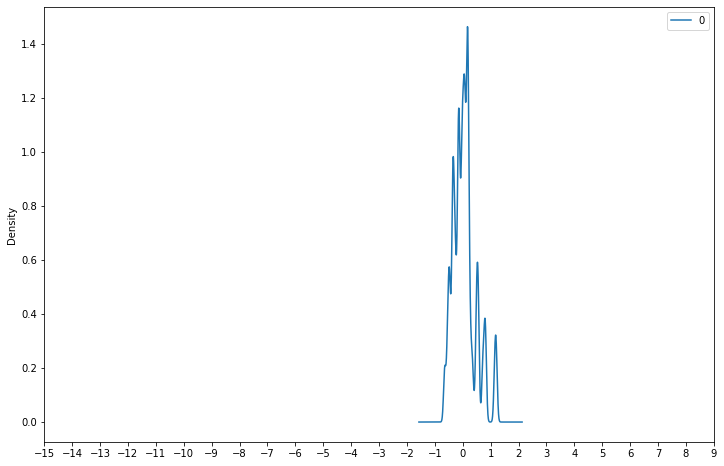

In [21]:
diffs = []
mod = False
for y_t_s, y_p_s in zip(y_test, y_pred):
    if mod:
        diff = abs(y_t_s - y_p_s)
        diffs.append(diff)
    else:
        diff = y_t_s - y_p_s
        diffs.append(diff)

y_pred_df = pd.DataFrame(diffs)
y_pred_df.plot.kde(bw_method=0.1, xticks=range(-15, 10), figsize=(12, 8))

<AxesSubplot:ylabel='Density'>

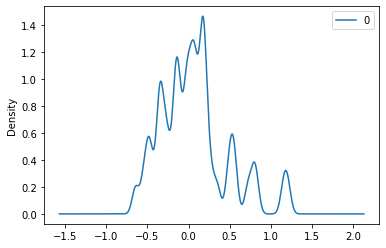

In [22]:
diffs = []
mod = False
for y_t_s, y_p_s in zip(y_test, y_pred):
    if mod:
        diff = abs(y_t_s - y_p_s)
        diffs.append(diff)
    else:
        diff = y_t_s - y_p_s
        diffs.append(diff)

y_pred_df = pd.DataFrame(diffs)
y_pred_df.plot.kde(bw_method=0.1)

<AxesSubplot:ylabel='Density'>

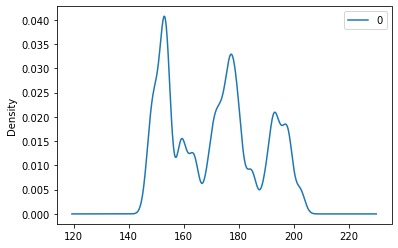

In [23]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.plot.kde(bw_method=0.1)

<AxesSubplot:ylabel='Density'>

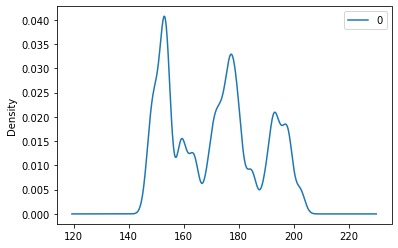

In [24]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.plot.kde(bw_method=0.1)

# Boolean Features bruteforce 

In [25]:
feature_combinations = list(itertools.product([True, False], repeat=6))

In [26]:
for f_set in feature_combinations:
    i = 0
    mixed_df = df
    X_train_mixed, X_test_mixed, Y_train_mixed, Y_test_mixed = train_test_split(mixed_df.drop(["projectile_angle_degrees", 'is_hit', 'projectile_intersection_x', 'projectile_intersection_y'], axis=1), mixed_df["projectile_angle_degrees"], test_size=0.33, shuffle=False)
    keys = ["thief_spawn_x", 
    "thief_spawn_y",
    "thief_speed",
    "projectile_spawn_x",
    "projectile_spawn_y",
    "projectile_speed"
]
    model_features = dict(zip(keys, f_set))
    for key in keys:
        if model_features[key] == False:
            i+=1
            X_train_mixed = X_train_mixed.drop([key], axis=1)
            X_test_mixed = X_test_mixed.drop([key], axis=1)
    if i == 0:
        mixed_reg = LinearRegression().fit(X_train_mixed, Y_train_mixed)
        Y_mixed_pred = mixed_reg.predict(X_test_mixed)
        mixed_reg_score = mean_squared_error(Y_test_mixed, Y_mixed_pred, squared=False)
        if mixed_reg_score < 30:
            print(f"Params: {model_features}")
            print(mixed_reg_score, "\n")

Params: {'thief_spawn_x': True, 'thief_spawn_y': True, 'thief_speed': True, 'projectile_spawn_x': True, 'projectile_spawn_y': True, 'projectile_speed': True}
0.4109655989163723 



In [27]:
y_train.shape, Y_train_mixed.shape

((103,), (103,))

In [32]:
reg.predict(X_test[0:2])

array([153.82073408, 193.07955718])

In [29]:
thief_spawn_y=1
Param(thief_spawn_y).value

1

In [34]:
print(X_test[0:1].shape)

(1, 6)


In [31]:
print(y_test)

65919    154.01
67940    193.56
68011    176.86
72086    185.86
73082    179.44
73173    196.13
73493    168.00
73880    153.42
74354    154.87
74521    149.98
75896    150.15
75922    148.78
76037    198.79
76043    148.23
77885    163.32
77971    189.82
78569    180.83
78599    197.70
78608    192.95
79492    174.87
80476    169.84
80931    178.17
81608    150.19
82948    151.56
83615    158.58
83685    176.73
83848    158.63
85015    170.94
86069    152.61
86084    151.94
86337    193.37
86449    159.17
86642    173.21
87225    153.56
87490    195.24
87874    184.04
88223    176.80
88277    161.54
88333    152.78
89236    171.23
89258    201.98
90520    172.67
90822    191.69
91348    153.68
93240    163.54
95101    178.53
95185    179.67
95989    176.67
98117    173.62
98678    153.31
99646    197.72
Name: projectile_angle_degrees, dtype: float64
